Сделайте несколько усовершенствований в предсказании временного ряда

1. Добавьте к исходному временному ряду следующие данные, в виде новых каналов:

попарные разности каналов
модули попарных разностей каналов
попарные произведения каналов
обратное значение каналов x_new = 1/(x + 1e-3)
первые производные каналов (x[n] - x[n-1])
вторые производные каналов (x[n] - 2*x[n-1] + x[n-2])
* каналы - столбцы датафрейма OPEN, MAX, MIN, CLOSE.

2. Сделайте предсказание нейросети, сравните эталонный сигнал с настоящим. При формировании входного сигнала используйте:

100 точек с шагом назад по 1
100 точек с шагом назад по 10 (или сами точки, или среднее по отрезку в 10 точек)

#Прогнозирование акций Лукойл




In [ ]:
import matplotlib.pyplot as plt # Подключаем matplotlib
import numpy as np # Подключаем numpy
import seaborn as sns
sns.set_style('darkgrid')

In [ ]:
#Загружаем библиотеки

import pandas as pd #Пандас
import matplotlib.pyplot as plt #Отрисовка графиков
from tensorflow.keras.utils import to_categorical 
import numpy as np #Numpy
from tensorflow.keras.optimizers import Adam #Оптимизатор
from tensorflow.keras.models import Sequential, Model #Два варианты моделей
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D, RepeatVector #Стандартные слои
from sklearn.preprocessing import StandardScaler, MinMaxScaler #Нормировщики
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # для генерации выборки временных рядов

import warnings
warnings.filterwarnings("ignore")
# Рисовать графики сразу же
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Считываем данные с помощью pandas
base_data = pd.read_csv('/content/drive/MyDrive/Базы/18_19.csv', sep=';')

In [ ]:
#Выводим пять первых строк
base_data.head()

,DATE,TIME,OPEN,MAX,MIN,CLOSE,VOLUME
0,03.01.2018,10:00:00,3341.0,3356.0,3340.0,3355.0,6088
1,03.01.2018,10:01:00,3355.0,3359.0,3353.0,3353.0,1624
2,03.01.2018,10:02:00,3351.5,3357.5,3351.5,3357.5,722
3,03.01.2018,10:03:00,3354.5,3360.0,3354.5,3358.0,3034
4,03.01.2018,10:04:00,3358.0,3360.0,3351.5,3360.0,1427


In [ ]:
#Выцепялем numpy значения .values
#И выводим нулевой
txt = base_data.values[0]
print(txt)

['03.01.2018' '10:00:00' 3341.0 3356.0 3340.0 3355.0 6088]


In [ ]:
base_data16 = pd.read_csv('/content/drive/MyDrive/Базы/16_17.csv', sep=';')
base_data18 = pd.read_csv('/content/drive/MyDrive/Базы/18_19.csv', sep=';')
data16_17 = base_data16.iloc[:,2:]
data18_19 = base_data18.iloc[:,2:]

In [ ]:
data16_17.shape[0]

263925

In [ ]:
# Выводим параметры одного файла
d = data18_19
print(len(d)) # Сколько есть записей
print(len(d.iloc[0])) # Длина одной строки данных
print(d.iloc[0]) # Пример первой строки данных

217947
5
OPEN      3341.0
MAX       3356.0
MIN       3340.0
CLOSE     3355.0
VOLUME    6088.0
Name: 0, dtype: float64


In [ ]:
# Объединяем базы из двух файлов
data = data16_17.copy()                 # Создаем копию первой базы
data = pd.concat([data16_17,data18_19]) # Присоединяем к ней вторую базу


In [ ]:
data.head()

,OPEN,MAX,MIN,CLOSE,VOLUME
0,2351.0,2355.8,2350.0,2350.0,2547
1,2352.9,2355.7,2350.0,2355.7,195
2,2355.6,2356.0,2351.4,2354.1,257
3,2354.5,2355.0,2351.2,2353.7,763
4,2353.1,2353.9,2353.1,2353.6,231


In [ ]:
data=data.astype({'VOLUME': 'float64'})
data.VOLUME.head()

0    2547.0
1     195.0
2     257.0
3     763.0
4     231.0
Name: VOLUME, dtype: float64

In [ ]:
data.head()

,OPEN,MAX,MIN,CLOSE,VOLUME
0,2351.0,2355.8,2350.0,2350.0,2547.0
1,2352.9,2355.7,2350.0,2355.7,195.0
2,2355.6,2356.0,2351.4,2354.1,257.0
3,2354.5,2355.0,2351.2,2353.7,763.0
4,2353.1,2353.9,2353.1,2353.6,231.0


In [ ]:
data['prom']=data['OPEN']-data['MAX']     # Добавляем попарные разности каналов
data['promin']=data['OPEN']-data['MIN']
data['proc']=data['OPEN']-data['CLOSE']
data['prmm']=data['MIN']-data['MAX']
data['prmc']=data['MIN']-data['CLOSE']
data['prmaxc']=data['MAX']-data['CLOSE']

In [ ]:
data.head(5)

,OPEN,MAX,MIN,CLOSE,VOLUME,prom,promin,proc,prmm,prmc,prmaxc
0,2351.0,2355.8,2350.0,2350.0,2547.0,-4.8,1.0,1.0,-5.8,0.0,5.8
1,2352.9,2355.7,2350.0,2355.7,195.0,-2.8,2.9,-2.8,-5.7,-5.7,0.0
2,2355.6,2356.0,2351.4,2354.1,257.0,-0.4,4.2,1.5,-4.6,-2.7,1.9
3,2354.5,2355.0,2351.2,2353.7,763.0,-0.5,3.3,0.8,-3.8,-2.5,1.3
4,2353.1,2353.9,2353.1,2353.6,231.0,-0.8,0.0,-0.5,-0.8,-0.5,0.3


In [ ]:
data['mprom']=(data['OPEN']-data['MAX']).abs()     # Добавляем модули попарных разностей каналов
data['mpromin']=(data['OPEN']-data['MIN']).abs()
data['mproc']=(data['OPEN']-data['CLOSE']).abs()
data['mprmm']=(data['MIN']-data['MAX']).abs()
data['mprmc']=(data['MIN']-data['CLOSE']).abs()
data['mprmaxc']=(data['MAX']-data['CLOSE']).abs()

In [ ]:
data.head(5)

,OPEN,MAX,MIN,CLOSE,VOLUME,prom,promin,proc,prmm,prmc,prmaxc,mprom,mpromin,mproc,mprmm,mprmc,mprmaxc
0,2351.0,2355.8,2350.0,2350.0,2547.0,-4.8,1.0,1.0,-5.8,0.0,5.8,4.8,1.0,1.0,5.8,0.0,5.8
1,2352.9,2355.7,2350.0,2355.7,195.0,-2.8,2.9,-2.8,-5.7,-5.7,0.0,2.8,2.9,2.8,5.7,5.7,0.0
2,2355.6,2356.0,2351.4,2354.1,257.0,-0.4,4.2,1.5,-4.6,-2.7,1.9,0.4,4.2,1.5,4.6,2.7,1.9
3,2354.5,2355.0,2351.2,2353.7,763.0,-0.5,3.3,0.8,-3.8,-2.5,1.3,0.5,3.3,0.8,3.8,2.5,1.3
4,2353.1,2353.9,2353.1,2353.6,231.0,-0.8,0.0,-0.5,-0.8,-0.5,0.3,0.8,0.0,0.5,0.8,0.5,0.3


In [ ]:
data['ppom']=data['OPEN']*data['MAX']     # Добавляем попарные произведения каналов
data['ppomin']=data['OPEN']*data['MIN']
data['ppoc']=data['OPEN']*data['CLOSE']
data['ppmm']=data['MIN']*data['MAX']
data['ppmc']=data['MIN']*data['CLOSE']
data['ppmaxc']=data['MAX']*data['CLOSE']

In [ ]:
data.head()

,OPEN,MAX,MIN,CLOSE,VOLUME,prom,promin,proc,prmm,prmc,prmaxc,mprom,mpromin,mproc,mprmm,mprmc,mprmaxc,ppom,ppomin,ppoc,ppmm,ppmc,ppmaxc
0,2351.0,2355.8,2350.0,2350.0,2547.0,-4.8,1.0,1.0,-5.8,0.0,5.8,4.8,1.0,1.0,5.8,0.0,5.8,5538485.80,5524850.00,5524850.00,5536130.00,5522500.00,5536130.00
1,2352.9,2355.7,2350.0,2355.7,195.0,-2.8,2.9,-2.8,-5.7,-5.7,0.0,2.8,2.9,2.8,5.7,5.7,0.0,5542726.53,5529315.00,5542726.53,5535895.00,5535895.00,5549322.49
2,2355.6,2356.0,2351.4,2354.1,257.0,-0.4,4.2,1.5,-4.6,-2.7,1.9,0.4,4.2,1.5,4.6,2.7,1.9,5549793.60,5538957.84,5545317.96,5539898.40,5535430.74,5546259.60
3,2354.5,2355.0,2351.2,2353.7,763.0,-0.5,3.3,0.8,-3.8,-2.5,1.3,0.5,3.3,0.8,3.8,2.5,1.3,5544847.50,5535900.40,5541786.65,5537076.00,5534019.44,5542963.50
4,2353.1,2353.9,2353.1,2353.6,231.0,-0.8,0.0,-0.5,-0.8,-0.5,0.3,0.8,0.0,0.5,0.8,0.5,0.3,5538962.09,5537079.61,5538256.16,5538962.09,5538256.16,5540139.04


In [ ]:
data['ozom']=1/(data['OPEN']+1e-3)     # Добавляем обратные значения каналов
data['ozomin']=1/(data['MIN']+1e-3)
data['ozoc']=1/(data['MAX']+1e-3)
data['ozmm']=1/(data['CLOSE']+1e-3)

In [ ]:
data.head()

,OPEN,MAX,MIN,CLOSE,VOLUME,prom,promin,proc,prmm,prmc,prmaxc,mprom,mpromin,mproc,mprmm,mprmc,mprmaxc,ppom,ppomin,ppoc,ppmm,ppmc,ppmaxc,ozom,ozomin,ozoc,ozmm
0,2351.0,2355.8,2350.0,2350.0,2547.0,-4.8,1.0,1.0,-5.8,0.0,5.8,4.8,1.0,1.0,5.8,0.0,5.8,5538485.80,5524850.00,5524850.00,5536130.00,5522500.00,5536130.00,0.000425,0.000426,0.000424,0.000426
1,2352.9,2355.7,2350.0,2355.7,195.0,-2.8,2.9,-2.8,-5.7,-5.7,0.0,2.8,2.9,2.8,5.7,5.7,0.0,5542726.53,5529315.00,5542726.53,5535895.00,5535895.00,5549322.49,0.000425,0.000426,0.000425,0.000425
2,2355.6,2356.0,2351.4,2354.1,257.0,-0.4,4.2,1.5,-4.6,-2.7,1.9,0.4,4.2,1.5,4.6,2.7,1.9,5549793.60,5538957.84,5545317.96,5539898.40,5535430.74,5546259.60,0.000425,0.000425,0.000424,0.000425
3,2354.5,2355.0,2351.2,2353.7,763.0,-0.5,3.3,0.8,-3.8,-2.5,1.3,0.5,3.3,0.8,3.8,2.5,1.3,5544847.50,5535900.40,5541786.65,5537076.00,5534019.44,5542963.50,0.000425,0.000425,0.000425,0.000425
4,2353.1,2353.9,2353.1,2353.6,231.0,-0.8,0.0,-0.5,-0.8,-0.5,0.3,0.8,0.0,0.5,0.8,0.5,0.3,5538962.09,5537079.61,5538256.16,5538962.09,5538256.16,5540139.04,0.000425,0.000425,0.000425,0.000425


In [ ]:
data['fpop']=data['OPEN'].diff(periods = 1)     # Добавляем первые производные каналов
data['fpomin']=data['MIN'].diff(periods = 1)
data['fmax']=data['MAX'].diff(periods = 1)
data['fpcl']=data['CLOSE'].diff(periods = 1)
data['fpop'][0]=1
data['fpomin'][0]=1
data['fmax'][0]=1
data['fpcl'][0]=1

In [ ]:
data.head()

,OPEN,MAX,MIN,CLOSE,VOLUME,prom,promin,proc,prmm,prmc,prmaxc,mprom,mpromin,mproc,mprmm,mprmc,mprmaxc,ppom,ppomin,ppoc,ppmm,ppmc,ppmaxc,ozom,ozomin,ozoc,ozmm,fpop,fpomin,fmax,fpcl
0,2351.0,2355.8,2350.0,2350.0,2547.0,-4.8,1.0,1.0,-5.8,0.0,5.8,4.8,1.0,1.0,5.8,0.0,5.8,5538485.80,5524850.00,5524850.00,5536130.00,5522500.00,5536130.00,0.000425,0.000426,0.000424,0.000426,1.0,1.0,1.0,1.0
1,2352.9,2355.7,2350.0,2355.7,195.0,-2.8,2.9,-2.8,-5.7,-5.7,0.0,2.8,2.9,2.8,5.7,5.7,0.0,5542726.53,5529315.00,5542726.53,5535895.00,5535895.00,5549322.49,0.000425,0.000426,0.000425,0.000425,1.9,0.0,-0.1,5.7
2,2355.6,2356.0,2351.4,2354.1,257.0,-0.4,4.2,1.5,-4.6,-2.7,1.9,0.4,4.2,1.5,4.6,2.7,1.9,5549793.60,5538957.84,5545317.96,5539898.40,5535430.74,5546259.60,0.000425,0.000425,0.000424,0.000425,2.7,1.4,0.3,-1.6
3,2354.5,2355.0,2351.2,2353.7,763.0,-0.5,3.3,0.8,-3.8,-2.5,1.3,0.5,3.3,0.8,3.8,2.5,1.3,5544847.50,5535900.40,5541786.65,5537076.00,5534019.44,5542963.50,0.000425,0.000425,0.000425,0.000425,-1.1,-0.2,-1.0,-0.4
4,2353.1,2353.9,2353.1,2353.6,231.0,-0.8,0.0,-0.5,-0.8,-0.5,0.3,0.8,0.0,0.5,0.8,0.5,0.3,5538962.09,5537079.61,5538256.16,5538962.09,5538256.16,5540139.04,0.000425,0.000425,0.000425,0.000425,-1.4,1.9,-1.1,-0.1


In [ ]:
data['spop']=data['OPEN'] - 2*data['OPEN'].shift(1) + data['OPEN'].shift(2)     # Добавляем вторые производные каналов
data['spomin']=data['MIN'] - 2*data['MIN'].shift(1) + data['MIN'].shift(2)
data['spmax']=data['MAX'] - 2*data['MAX'].shift(1) + data['MAX'].shift(2)
data['spcl']=data['CLOSE'] - 2*data['CLOSE'].shift(1) + data['CLOSE'].shift(2)
data['spop'][0:2]=1
data['spomin'][0:2]=1
data['spmax'][0:2]=1
data['spcl'][0:2]=1

In [ ]:
data.head()

,OPEN,MAX,MIN,CLOSE,VOLUME,prom,promin,proc,prmm,prmc,prmaxc,mprom,mpromin,mproc,mprmm,mprmc,mprmaxc,ppom,ppomin,ppoc,ppmm,ppmc,ppmaxc,ozom,ozomin,ozoc,ozmm,fpop,fpomin,fmax,fpcl,spop,spomin,spmax,spcl
0,2351.0,2355.8,2350.0,2350.0,2547.0,-4.8,1.0,1.0,-5.8,0.0,5.8,4.8,1.0,1.0,5.8,0.0,5.8,5538485.80,5524850.00,5524850.00,5536130.00,5522500.00,5536130.00,0.000425,0.000426,0.000424,0.000426,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2352.9,2355.7,2350.0,2355.7,195.0,-2.8,2.9,-2.8,-5.7,-5.7,0.0,2.8,2.9,2.8,5.7,5.7,0.0,5542726.53,5529315.00,5542726.53,5535895.00,5535895.00,5549322.49,0.000425,0.000426,0.000425,0.000425,1.9,0.0,-0.1,5.7,1.0,1.0,1.0,1.0
2,2355.6,2356.0,2351.4,2354.1,257.0,-0.4,4.2,1.5,-4.6,-2.7,1.9,0.4,4.2,1.5,4.6,2.7,1.9,5549793.60,5538957.84,5545317.96,5539898.40,5535430.74,5546259.60,0.000425,0.000425,0.000424,0.000425,2.7,1.4,0.3,-1.6,0.8,1.4,0.4,-7.3
3,2354.5,2355.0,2351.2,2353.7,763.0,-0.5,3.3,0.8,-3.8,-2.5,1.3,0.5,3.3,0.8,3.8,2.5,1.3,5544847.50,5535900.40,5541786.65,5537076.00,5534019.44,5542963.50,0.000425,0.000425,0.000425,0.000425,-1.1,-0.2,-1.0,-0.4,-3.8,-1.6,-1.3,1.2
4,2353.1,2353.9,2353.1,2353.6,231.0,-0.8,0.0,-0.5,-0.8,-0.5,0.3,0.8,0.0,0.5,0.8,0.5,0.3,5538962.09,5537079.61,5538256.16,5538962.09,5538256.16,5540139.04,0.000425,0.000425,0.000425,0.000425,-1.4,1.9,-1.1,-0.1,-0.3,2.1,-0.1,0.3


In [ ]:
data

,OPEN,MAX,MIN,CLOSE,VOLUME,prom,promin,proc,prmm,prmc,prmaxc,mprom,mpromin,mproc,mprmm,mprmc,mprmaxc,ppom,ppomin,ppoc,ppmm,ppmc,ppmaxc,ozom,ozomin,ozoc,ozmm,fpop,fpomin,fmax,fpcl,spop,spomin,spmax,spcl
0,2351.0,2355.8,2350.0,2350.0,2547.0,-4.8,1.0,1.0,-5.8,0.0,5.8,4.8,1.0,1.0,5.8,0.0,5.8,5538485.80,5524850.00,5524850.00,5536130.00,5522500.00,5536130.00,0.000425,0.000426,0.000424,0.000426,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2352.9,2355.7,2350.0,2355.7,195.0,-2.8,2.9,-2.8,-5.7,-5.7,0.0,2.8,2.9,2.8,5.7,5.7,0.0,5542726.53,5529315.00,5542726.53,5535895.00,5535895.00,5549322.49,0.000425,0.000426,0.000425,0.000425,1.9,0.0,-0.1,5.7,1.0,1.0,1.0,1.0
2,2355.6,2356.0,2351.4,2354.1,257.0,-0.4,4.2,1.5,-4.6,-2.7,1.9,0.4,4.2,1.5,4.6,2.7,1.9,5549793.60,5538957.84,5545317.96,5539898.40,5535430.74,5546259.60,0.000425,0.000425,0.000424,0.000425,2.7,1.4,0.3,-1.6,0.8,1.4,0.4,-7.3
3,2354.5,2355.0,2351.2,2353.7,763.0,-0.5,3.3,0.8,-3.8,-2.5,1.3,0.5,3.3,0.8,3.8,2.5,1.3,5544847.50,5535900.40,5541786.65,5537076.00,5534019.44,5542963.50,0.000425,0.000425,0.000425,0.000425,-1.1,-0.2,-1.0,-0.4,-3.8,-1.6,-1.3,1.2
4,2353.1,2353.9,2353.1,2353.6,231.0,-0.8,0.0,-0.5,-0.8,-0.5,0.3,0.8,0.0,0.5,0.8,0.5,0.3,5538962.09,5537079.61,5538256.16,5538962.09,5538256.16,5540139.04,0.000425,0.000425,0.000425,0.000425,-1.4,1.9,-1.1,-0.1,-0.3,2.1,-0.1,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217942,5183.5,5183.5,5183.5,5183.5,31523.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26868672.25,26868672.25,26868672.25,26868672.25,26868672.25,26868672.25,0.000193,0.000193,0.000193,0.000193,13.5,16.0,11.5,11.5,13.5,18.0,11.5,10.0
217943,5183.5,5183.5,5183.5,5183.5,5090.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26868672.25,26868672.25,26868672.25,26868672.25,26868672.25,26868672.25,0.000193,0.000193,0.000193,0.000193,0.0,0.0,0.0,0.0,-13.5,-16.0,-11.5,-11.5
217944,5183.5,5183.5,5183.5,5183.5,230.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26868672.25,26868672.25,26868672.25,26868672.25,26868672.25,26868672.25,0.000193,0.000193,0.000193,0.000193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
217945,5183.5,5183.5,5183.5,5183.5,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26868672.25,26868672.25,26868672.25,26868672.25,26868672.25,26868672.25,0.000193,0.000193,0.000193,0.000193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 481872 entries, 0 to 217946
Data columns (total 35 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   OPEN     481872 non-null  float64
 1   MAX      481872 non-null  float64
 2   MIN      481872 non-null  float64
 3   CLOSE    481872 non-null  float64
 4   VOLUME   481872 non-null  float64
 5   prom     481872 non-null  float64
 6   promin   481872 non-null  float64
 7   proc     481872 non-null  float64
 8   prmm     481872 non-null  float64
 9   prmc     481872 non-null  float64
 10  prmaxc   481872 non-null  float64
 11  mprom    481872 non-null  float64
 12  mpromin  481872 non-null  float64
 13  mproc    481872 non-null  float64
 14  mprmm    481872 non-null  float64
 15  mprmc    481872 non-null  float64
 16  mprmaxc  481872 non-null  float64
 17  ppom     481872 non-null  float64
 18  ppomin   481872 non-null  float64
 19  ppoc     481872 non-null  float64
 20  ppmm     481872 non-null  

In [ ]:
data = np.array(data)                   # Превращаем в numpy массив

In [ ]:
# Сравниваем размеры
print(len(data16_17)) # Выводим размер первой базы
print(len(data18_19)) # Выводим размер второй базы
print(len(data))      # Выводим размер суммарной базы

263925
217947
481872


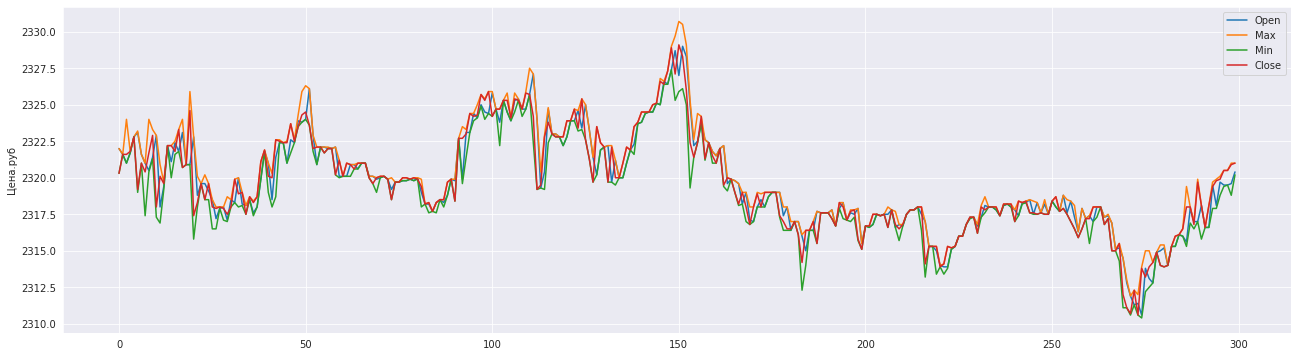

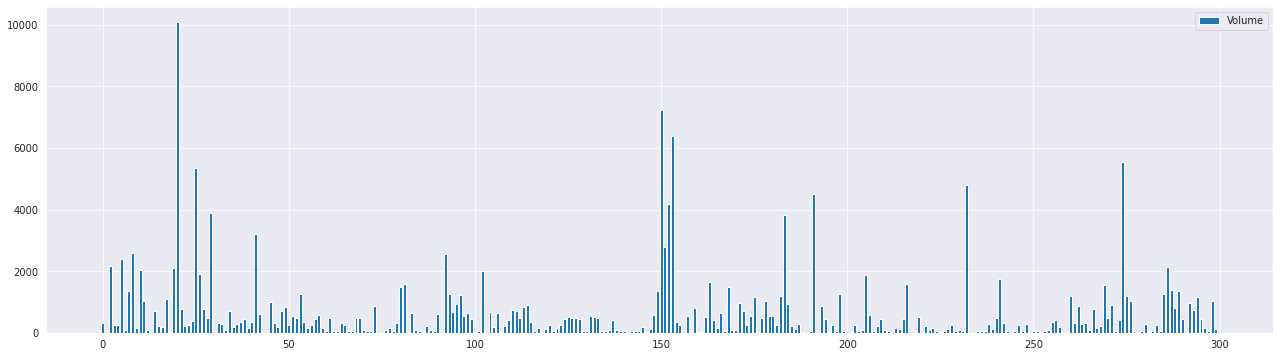

In [ ]:
#Отображаем исходные от точки start и длинной stop
start = 100            #С какой точки начинаем
#stop = data.shape[0] #Сколько точек отрисуем
length = 300 #Сколько точек отрисуем

#Заполняем текстовые названия каналов данных
chanelNames = ['Open', 'Max', 'Min', 'Close', 'Volume']

#Рисуем все графики данных
#ЧЕтыре основных канала - open, max, min, close
plt.figure(figsize=(22,6))
for i in range(4):
  #Отрисовываем часть данных
  #От начальной точки, до начальной точки + размер шага отрисовки
  plt.plot(data[start:start+length,i], 
          label=chanelNames[i])
plt.ylabel('Цена.руб')
plt.legend()
plt.show()

#Канал volume
plt.figure(figsize=(22,6))
plt.bar(x=np.arange(length), height=data[start:start+length,4], label="Volume")
plt.legend()
plt.show()

### Использование TimeseriesGenerator

In [ ]:
import numpy as np # Подключаем numpy
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # Подлкючаем модуль TimeseriesGenerator

In [ ]:
test_array = np.arange(50) # Создаем тестовый массив из полседовательности чисел от 0 до 50
print(test_array) # Выводим на экран созданный массив

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]


In [ ]:
x_train = test_array # Создаем x_train
y_train = test_array # Создаем y_train

# Создаем генератор
gen = TimeseriesGenerator(
    x_train,
    y_train,
    length= 10,
    sampling_rate=1,
    stride=1,
    batch_size=5
    )

In [ ]:
# Формируем цикл for для прохождения по элементам генератора
for i, g in enumerate(gen):
  print('Батч №', i)
  print('x_train:', g[0])
  print('y_train:', g[1])
  print()

Батч № 0
x_train: [[ 0  1  2  3  4  5  6  7  8  9]
 [ 1  2  3  4  5  6  7  8  9 10]
 [ 2  3  4  5  6  7  8  9 10 11]
 [ 3  4  5  6  7  8  9 10 11 12]
 [ 4  5  6  7  8  9 10 11 12 13]]
y_train: [10 11 12 13 14]

Батч № 1
x_train: [[ 5  6  7  8  9 10 11 12 13 14]
 [ 6  7  8  9 10 11 12 13 14 15]
 [ 7  8  9 10 11 12 13 14 15 16]
 [ 8  9 10 11 12 13 14 15 16 17]
 [ 9 10 11 12 13 14 15 16 17 18]]
y_train: [15 16 17 18 19]

Батч № 2
x_train: [[10 11 12 13 14 15 16 17 18 19]
 [11 12 13 14 15 16 17 18 19 20]
 [12 13 14 15 16 17 18 19 20 21]
 [13 14 15 16 17 18 19 20 21 22]
 [14 15 16 17 18 19 20 21 22 23]]
y_train: [20 21 22 23 24]

Батч № 3
x_train: [[15 16 17 18 19 20 21 22 23 24]
 [16 17 18 19 20 21 22 23 24 25]
 [17 18 19 20 21 22 23 24 25 26]
 [18 19 20 21 22 23 24 25 26 27]
 [19 20 21 22 23 24 25 26 27 28]]
y_train: [25 26 27 28 29]

Батч № 4
x_train: [[20 21 22 23 24 25 26 27 28 29]
 [21 22 23 24 25 26 27 28 29 30]
 [22 23 24 25 26 27 28 29 30 31]
 [23 24 25 26 27 28 29 30 31 32]
 [24 2

In [ ]:
x_train = test_array[:-1] # Создаем x_train
y_train = test_array[1:] # Создаем y_train

# Создаем генератор
gen = TimeseriesGenerator(
    x_train,
    y_train,
    length= 10,
    sampling_rate=1,
    stride=1,
    batch_size=1
    )
# Формируем цикл for для прохождения по элементам генератора
for i, g in enumerate(gen):
  print('Батч №', i)
  print('x_train:', g[0])
  print('y_train:', g[1])
  print()

Батч № 0
x_train: [[0 1 2 3 4 5 6 7 8 9]]
y_train: [11]

Батч № 1
x_train: [[ 1  2  3  4  5  6  7  8  9 10]]
y_train: [12]

Батч № 2
x_train: [[ 2  3  4  5  6  7  8  9 10 11]]
y_train: [13]

Батч № 3
x_train: [[ 3  4  5  6  7  8  9 10 11 12]]
y_train: [14]

Батч № 4
x_train: [[ 4  5  6  7  8  9 10 11 12 13]]
y_train: [15]

Батч № 5
x_train: [[ 5  6  7  8  9 10 11 12 13 14]]
y_train: [16]

Батч № 6
x_train: [[ 6  7  8  9 10 11 12 13 14 15]]
y_train: [17]

Батч № 7
x_train: [[ 7  8  9 10 11 12 13 14 15 16]]
y_train: [18]

Батч № 8
x_train: [[ 8  9 10 11 12 13 14 15 16 17]]
y_train: [19]

Батч № 9
x_train: [[ 9 10 11 12 13 14 15 16 17 18]]
y_train: [20]

Батч № 10
x_train: [[10 11 12 13 14 15 16 17 18 19]]
y_train: [21]

Батч № 11
x_train: [[11 12 13 14 15 16 17 18 19 20]]
y_train: [22]

Батч № 12
x_train: [[12 13 14 15 16 17 18 19 20 21]]
y_train: [23]

Батч № 13
x_train: [[13 14 15 16 17 18 19 20 21 22]]
y_train: [24]

Батч № 14
x_train: [[14 15 16 17 18 19 20 21 22 23]]
y_train: [25]



In [ ]:
x_train = test_array # Создаем x_train
y_train = [[x, x+1] for x in range(50)] # Создаем y_train

# Создаем генератор
gen = TimeseriesGenerator(
    x_train,
    y_train,
    length= 10,
    sampling_rate=1,
    stride=1,
    batch_size=1
    )
# Формируем цикл for для прохождения по элементам генератора
for i, g in enumerate(gen):
  print('Батч №', i)
  print('x_train:', g[0])
  print('y_train:', g[1])
  print()

Батч № 0
x_train: [[0 1 2 3 4 5 6 7 8 9]]
y_train: [[10 11]]

Батч № 1
x_train: [[ 1  2  3  4  5  6  7  8  9 10]]
y_train: [[11 12]]

Батч № 2
x_train: [[ 2  3  4  5  6  7  8  9 10 11]]
y_train: [[12 13]]

Батч № 3
x_train: [[ 3  4  5  6  7  8  9 10 11 12]]
y_train: [[13 14]]

Батч № 4
x_train: [[ 4  5  6  7  8  9 10 11 12 13]]
y_train: [[14 15]]

Батч № 5
x_train: [[ 5  6  7  8  9 10 11 12 13 14]]
y_train: [[15 16]]

Батч № 6
x_train: [[ 6  7  8  9 10 11 12 13 14 15]]
y_train: [[16 17]]

Батч № 7
x_train: [[ 7  8  9 10 11 12 13 14 15 16]]
y_train: [[17 18]]

Батч № 8
x_train: [[ 8  9 10 11 12 13 14 15 16 17]]
y_train: [[18 19]]

Батч № 9
x_train: [[ 9 10 11 12 13 14 15 16 17 18]]
y_train: [[19 20]]

Батч № 10
x_train: [[10 11 12 13 14 15 16 17 18 19]]
y_train: [[20 21]]

Батч № 11
x_train: [[11 12 13 14 15 16 17 18 19 20]]
y_train: [[21 22]]

Батч № 12
x_train: [[12 13 14 15 16 17 18 19 20 21]]
y_train: [[22 23]]

Батч № 13
x_train: [[13 14 15 16 17 18 19 20 21 22]]
y_train: [[23 24]]

In [ ]:
y_train = [[x, x+1] for x in range(50)]
print(y_train)

[[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11], [11, 12], [12, 13], [13, 14], [14, 15], [15, 16], [16, 17], [17, 18], [18, 19], [19, 20], [20, 21], [21, 22], [22, 23], [23, 24], [24, 25], [25, 26], [26, 27], [27, 28], [28, 29], [29, 30], [30, 31], [31, 32], [32, 33], [33, 34], [34, 35], [35, 36], [36, 37], [37, 38], [38, 39], [39, 40], [40, 41], [41, 42], [42, 43], [43, 44], [44, 45], [45, 46], [46, 47], [47, 48], [48, 49], [49, 50]]


### Функция загрузки данных




In [ ]:
#Формируем параметры загрузки данных

xLen = 100                      #Анализируем по 100 прошедшим точкам 
valLen = 30000                  #Используем 30.000 записей для проверки

trainLen = data.shape[0]-valLen # Размер тренировочной выборки

#Делим данные на тренировочную и тестовую выборки 
xTrain, xTest = data[:trainLen], data[trainLen+xLen+2:]

#Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

#Делаем reshape,т.к. у нас только один столбец по одному значению
yTrain, yTest = np.reshape(data[:trainLen,3],(-1,1)), np.reshape(data[trainLen+xLen+2:,3],(-1,1)) 
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

#Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain,           #В качестве параметров наши выборки
                               length=xLen, stride=1, sampling_rate=1, #Для каждой точки (из промежутка длины xLen)
                               batch_size=20)                #Размер batch, который будем скармливать модели

#Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, stride=1,
                               batch_size=20)

In [ ]:
print(trainDataGen[0][0].shape,
      trainDataGen[0][1].shape)

(20, 100, 35) (20, 1)


## Полносвязная сеть




## Визуализация результатов


In [ ]:
# Функция рассчитываем результаты прогнозирования сети
# В аргументы принимает сеть (currModel) и проверочную выборку
# Выдаёт результаты предсказания predVal
# И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
def getPred(currModel, xVal, yVal, yScaler):
  # Предсказываем ответ сети по проверочной выборке
  # И возвращаем исходны масштаб данных, до нормализации
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

# Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
# start - точка с которой начинаем отрисовку графика
# step - длина графика, которую отрисовываем
# channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.figure(figsize=(22,6))
  plt.plot(predVal[start:start+step, 0],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
# Функция расёта корреляции дух одномерных векторов
def correlate(a, b):
  # Рассчитываем основные показатели
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

# Функция рисуем корреляцию прогнозированного сигнала с правильным
# Смещая на различное количество шагов назад
# Для проверки появления эффекта автокорреляции
# channels - по каким каналам отображать корреляцию
# corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, 0]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага
    plt.figure(figsize=(14,7))
    plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

In [ ]:
print(len(xTest))

29898


In [ ]:
#Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(xTest, yTest,
                               length=100, sampling_rate=1,
                               batch_size=len(xTest)) #размер batch будет равен длине нашей выборки
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

## Dense-сетка

In [ ]:
#Создаём нейронку
modelD = Sequential()
modelD.add(Dense(150,input_shape = (xLen,35), activation="relu" )) # 35 - количество каналов
modelD.add(Flatten())
modelD.add(BatchNormalization())
modelD.add(Dense(1, activation="linear"))

#Компилируем
modelD.compile(loss="mse", optimizer=Adam(lr=1e-4),  metrics=['accuracy'])

modelD.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 100, 150)          5400      
                                                                 
 flatten_10 (Flatten)        (None, 15000)             0         
                                                                 
 batch_normalization_10 (Bat  (None, 15000)            60000     
 chNormalization)                                                
                                                                 
 dense_21 (Dense)            (None, 1)                 15001     
                                                                 
Total params: 80,401
Trainable params: 50,401
Non-trainable params: 30,000
_________________________________________________________________


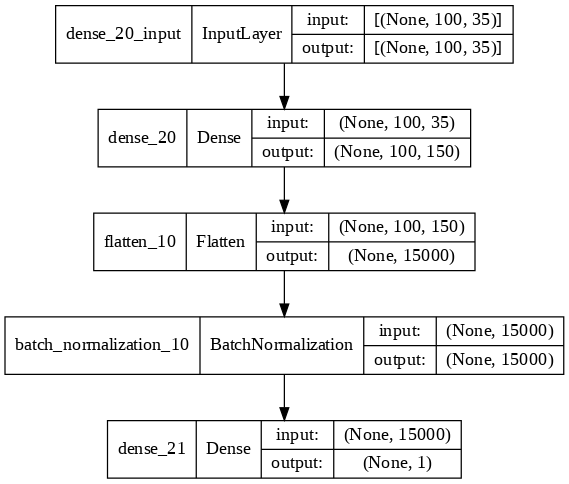

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(modelD, dpi=90,  show_shapes=True)

In [ ]:
# Запускаем обучение
history = modelD.fit(
                    trainDataGen, 
                    epochs=50, batch_size=256,
                    verbose=1, 
                    validation_data = testDataGen 
                    )

Epoch 1/50
22589/22589 [==============================] - 192s 8ms/step - loss: 0.0623 - accuracy: 2.2135e-06 - val_loss: 0.6334 - val_accuracy: 0.0000e+00
Epoch 2/50
22589/22589 [==============================] - 188s 8ms/step - loss: 0.0616 - accuracy: 2.2135e-06 - val_loss: 1.0578 - val_accuracy: 0.0000e+00
Epoch 3/50
22589/22589 [==============================] - 191s 8ms/step - loss: 0.0613 - accuracy: 2.2135e-06 - val_loss: 3.8747e-04 - val_accuracy: 0.0000e+00
Epoch 4/50
22589/22589 [==============================] - 189s 8ms/step - loss: 0.0612 - accuracy: 2.2135e-06 - val_loss: 0.0153 - val_accuracy: 0.0000e+00
Epoch 5/50
22589/22589 [==============================] - 188s 8ms/step - loss: 0.0612 - accuracy: 2.2135e-06 - val_loss: 0.0216 - val_accuracy: 0.0000e+00
Epoch 6/50
22589/22589 [==============================] - 190s 8ms/step - loss: 0.0612 - accuracy: 2.2135e-06 - val_loss: 0.0637 - val_accuracy: 0.0000e+00
Epoch 7/50
22589/22589 [==============================] - 18

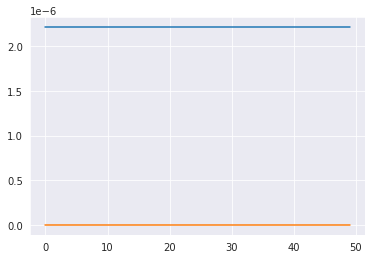

In [ ]:
# Выводим график точности распознавания на обучающей и проверочной выборках
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

In [ ]:
#Компилируем
modelD.compile(loss="mse", optimizer=Adam(lr=1e-5))
#Запускаем обучение
history = modelD.fit(
                    trainDataGen, 
                    epochs=20, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

Epoch 1/20
22589/22589 [==============================] - 189s 8ms/step - loss: 0.0607 - val_loss: 0.0078
Epoch 2/20
22589/22589 [==============================] - 186s 8ms/step - loss: 0.0606 - val_loss: 0.0012
Epoch 3/20
22589/22589 [==============================] - 186s 8ms/step - loss: 0.0606 - val_loss: 0.0049
Epoch 4/20
22589/22589 [==============================] - 184s 8ms/step - loss: 0.0606 - val_loss: 0.0093
Epoch 5/20
22589/22589 [==============================] - 180s 8ms/step - loss: 0.0606 - val_loss: 0.0025
Epoch 6/20
22589/22589 [==============================] - 182s 8ms/step - loss: 0.0606 - val_loss: 0.0073
Epoch 7/20
22589/22589 [==============================] - 183s 8ms/step - loss: 0.0606 - val_loss: 0.0155
Epoch 8/20
22589/22589 [==============================] - 186s 8ms/step - loss: 0.0606 - val_loss: 0.0142
Epoch 9/20
22589/22589 [==============================] - 180s 8ms/step - loss: 0.0606 - val_loss: 0.0047
Epoch 10/20
22589/22589 [=====================

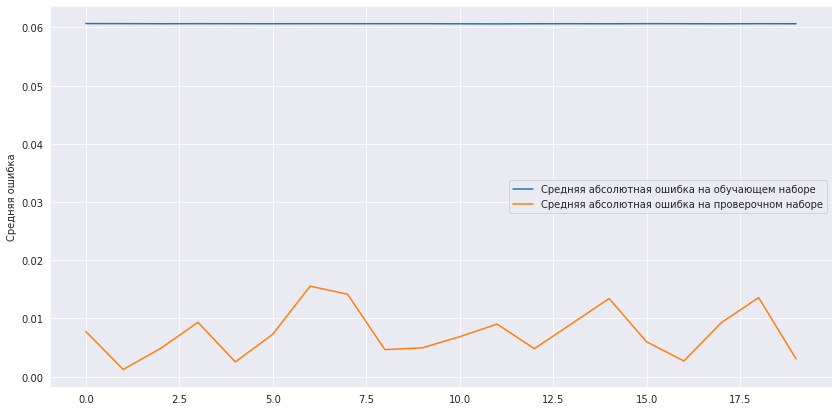

In [ ]:
#Выводим графики
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

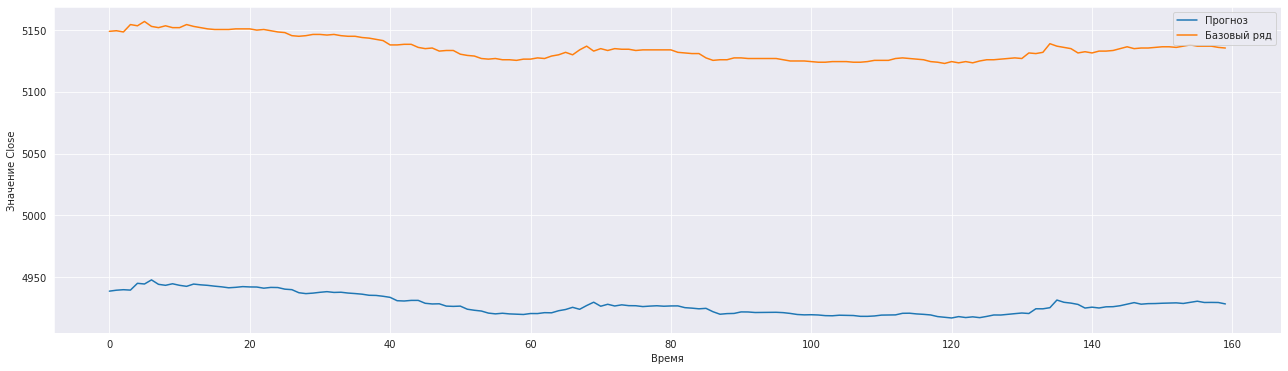

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelD #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler) #Прогнозируем данные

#Отображаем графики
showPredict(0, 160, 0, predVal, yValUnscaled)


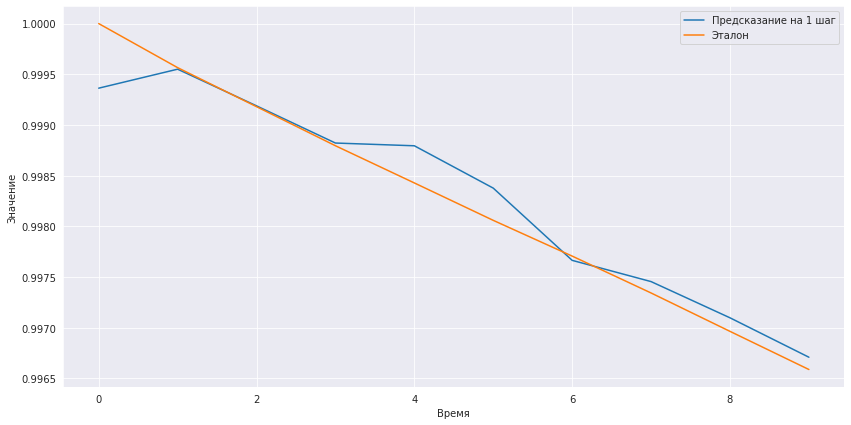

In [ ]:
#Отображаем корреляцию
#Используем выходной канал - только open
#Проверяем корреляцию на глубину 60 шагов
showCorr([0], 10, predVal, yValUnscaled)

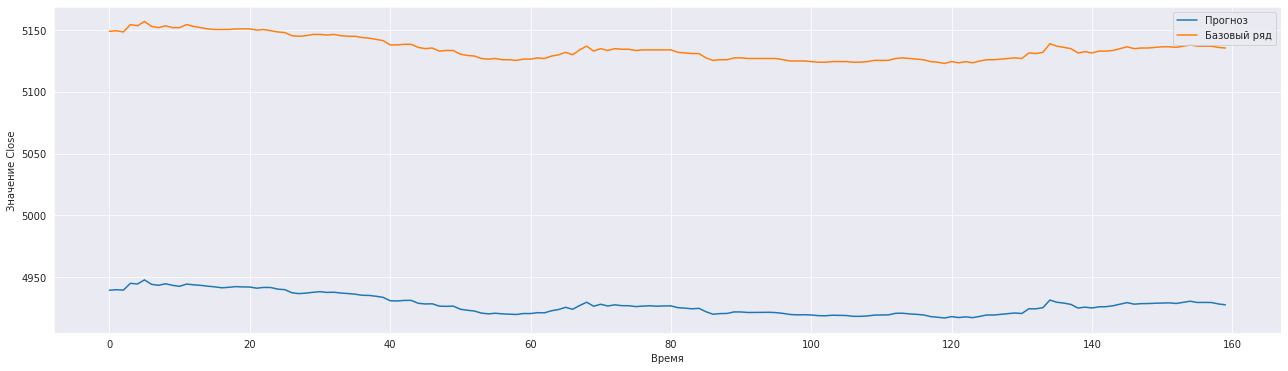

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelD #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler) #Прогнозируем данные

#Отображаем графики
showPredict(0, 160, 0, predVal[1:], yValUnscaled[:-1])


## Одномерная свёртка



In [ ]:
modelC = Sequential()

modelC.add(Conv1D(64, 35, input_shape = (xLen,35), activation="relu"))
modelC.add(Conv1D(64, 35, activation="relu"))
modelC.add(MaxPooling1D())
modelC.add(Flatten())
modelC.add(Dense(100, activation="relu"))
modelC.add(Dense(1, activation="linear"))

modelC.compile(loss="mse", optimizer=Adam(lr=1e-4))

modelC.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 66, 64)            78464     
                                                                 
 conv1d_1 (Conv1D)           (None, 32, 64)            143424    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 64)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 100)               102500    
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                        

In [ ]:
history = modelC.fit(trainDataGen,
                    epochs=20, 
                    verbose=1,
                    validation_data=testDataGen)

Epoch 1/20
22589/22589 [==============================] - 92s 4ms/step - loss: 8.7451e-05 - val_loss: 2.6868e-04
Epoch 2/20
22589/22589 [==============================] - 91s 4ms/step - loss: 6.6946e-05 - val_loss: 3.0025e-05
Epoch 3/20
22589/22589 [==============================] - 92s 4ms/step - loss: 5.8000e-05 - val_loss: 1.1084e-05
Epoch 4/20
22589/22589 [==============================] - 91s 4ms/step - loss: 6.4905e-05 - val_loss: 1.2085e-05
Epoch 5/20
22589/22589 [==============================] - 92s 4ms/step - loss: 5.2608e-05 - val_loss: 1.5350e-04
Epoch 6/20
22589/22589 [==============================] - 91s 4ms/step - loss: 5.2469e-05 - val_loss: 1.1904e-05
Epoch 7/20
22589/22589 [==============================] - 91s 4ms/step - loss: 4.9006e-05 - val_loss: 1.2263e-05
Epoch 8/20
22589/22589 [==============================] - 91s 4ms/step - loss: 4.3267e-05 - val_loss: 1.8225e-05
Epoch 9/20
22589/22589 [==============================] - 92s 4ms/step - loss: 3.9824e-05 - val_

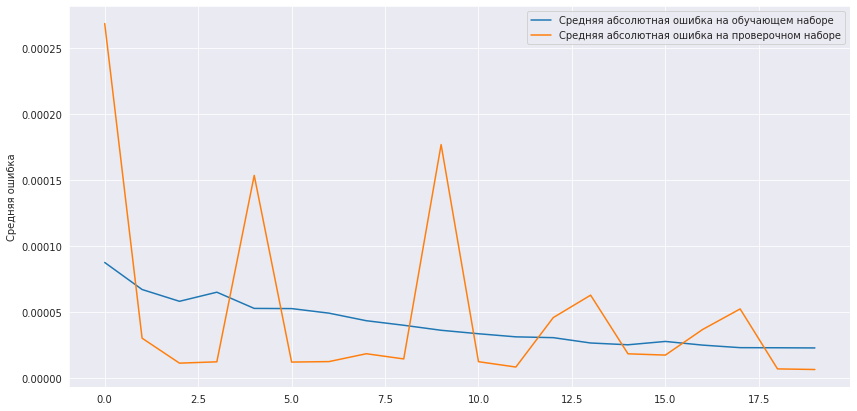

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelC
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

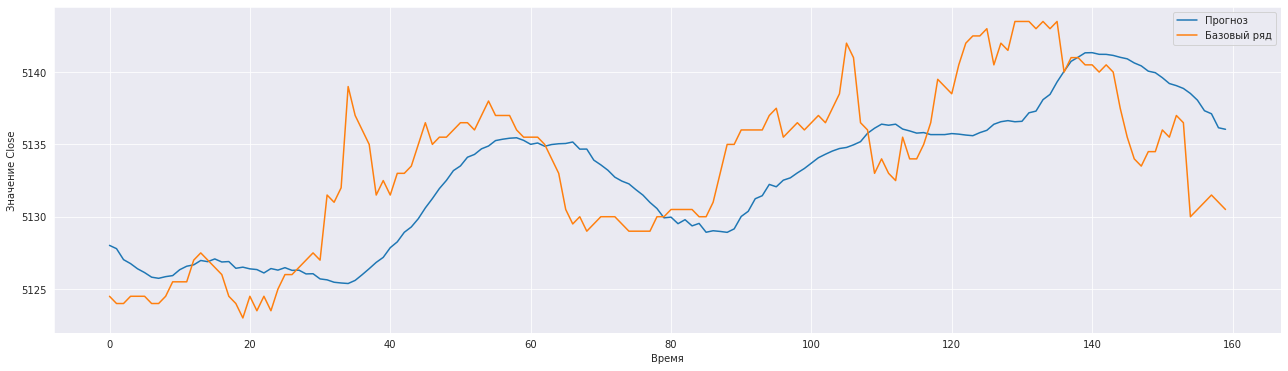

In [ ]:
#Отображаем графики
showPredict(100, 160, 0, predVal, yValUnscaled)

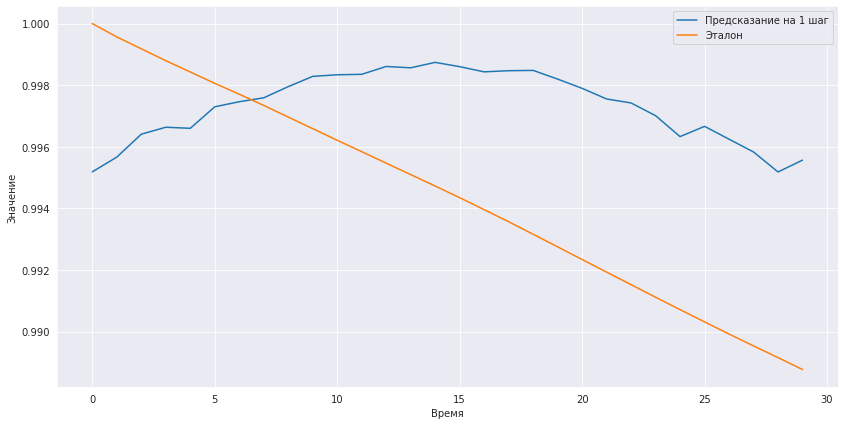

In [ ]:
#Отображаем корреляцию
showCorr([0], 30, predVal, yValUnscaled)

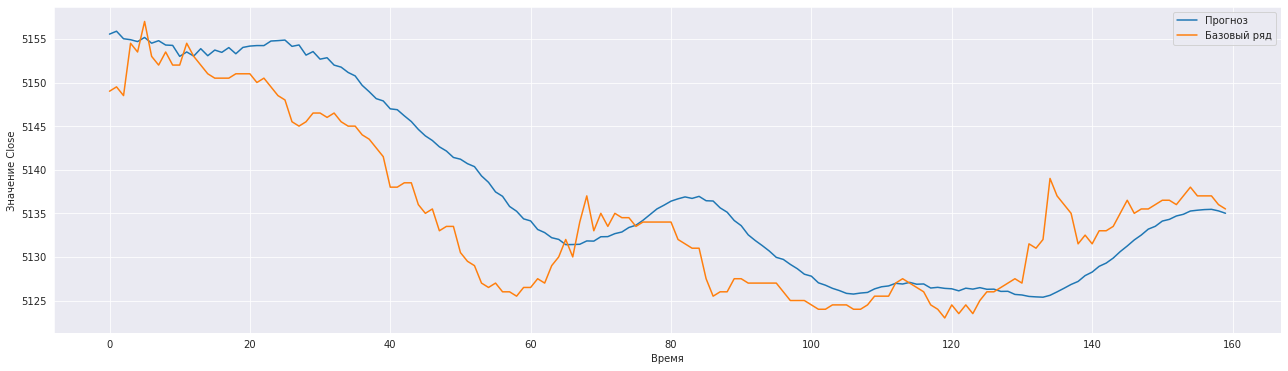

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelC #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler) #Прогнозируем данные

#Отображаем графики
showPredict(0, 160, 0, predVal[1:], yValUnscaled[:-1])


In [ ]:
#Формируем параметры загрузки данных

xLen = 100                      #Анализируем по 100 прошедшим точкам 
valLen = 30000                  #Используем 30.000 записей для проверки

trainLen = data.shape[0]-valLen # Размер тренировочной выборки

#Делим данные на тренировочную и тестовую выборки 
xTrain, xTest = data[:trainLen], data[trainLen+xLen+2:]

#Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

#Делаем reshape,т.к. у нас только один столбец по одному значению
yTrain, yTest = np.reshape(data[:trainLen,3],(-1,1)), np.reshape(data[trainLen+xLen+2:,3],(-1,1)) 
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

#Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain,           #В качестве параметров наши выборки
                               length=xLen, stride=1, sampling_rate=1, #Для каждой точки (из промежутка длины xLen)
                               batch_size=20)                #Размер batch, который будем скармливать модели

#Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, stride=1,
                               batch_size=20)

In [ ]:
print(trainDataGen[0][0].shape,
      trainDataGen[0][1].shape)

(20, 100, 35) (20, 1)


In [ ]:
# Функция рассчитываем результаты прогнозирования сети
# В аргументы принимает сеть (currModel) и проверочную выборку
# Выдаёт результаты предсказания predVal
# И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
def getPred(currModel, xVal, yVal, yScaler):
  # Предсказываем ответ сети по проверочной выборке
  # И возвращаем исходны масштаб данных, до нормализации
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

# Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
# start - точка с которой начинаем отрисовку графика
# step - длина графика, которую отрисовываем
# channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.figure(figsize=(22,6))
  plt.plot(predVal[start:start+step, 0],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
# Функция расчёта корреляции дух одномерных векторов
def correlate(a, b):
  # Рассчитываем основные показатели
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

# Функция рисуем корреляцию прогнозированного сигнала с правильным
# Смещая на различное количество шагов назад
# Для проверки появления эффекта автокорреляции
# channels - по каким каналам отображать корреляцию
# corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смеoении на i рагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, 0]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага
    plt.figure(figsize=(14,7))
    plt.plot(corr, label='Предсказание на ' + str(ch+10) + ' шаг') # Замена шага на 10
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

In [ ]:
print(len(xTest))

29898


In [ ]:
#Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(xTest, yTest,
                               length=100, sampling_rate=1,
                               batch_size=len(xTest)) #размер batch будет равен длине нашей выборки
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

In [ ]:
xVal.shape

(1, 29798, 100, 35)

In [ ]:
modelC = Sequential()

modelC.add(Conv1D(6, 4, input_shape = (xLen,35), activation="relu"))
modelC.add(Conv1D(6, 4, activation="relu"))
modelC.add(MaxPooling1D())
modelC.add(Flatten())
modelC.add(Dense(100, activation="relu"))
modelC.add(Dense(1, activation="linear"))

modelC.compile(loss="mse", optimizer=Adam(lr=1e-4))

modelC.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_27 (Conv1D)          (None, 97, 6)             846       
                                                                 
 conv1d_28 (Conv1D)          (None, 94, 6)             150       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 47, 6)            0         
 1D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 282)               0         
                                                                 
 dense_10 (Dense)            (None, 100)               28300     
                                                                 
 dense_11 (Dense)            (None, 1)                 101       
                                                     

In [ ]:
history = modelC.fit(trainDataGen,
                    epochs=10, 
                    verbose=1,
                    validation_data=testDataGen)

Epoch 1/10
22589/22589 [==============================] - 83s 4ms/step - loss: 5.2846e-04 - val_loss: 3.2311e-05
Epoch 2/10
22589/22589 [==============================] - 83s 4ms/step - loss: 4.2748e-05 - val_loss: 7.5527e-06
Epoch 3/10
22589/22589 [==============================] - 82s 4ms/step - loss: 3.0163e-05 - val_loss: 7.5742e-06
Epoch 4/10
22589/22589 [==============================] - 82s 4ms/step - loss: 2.6342e-05 - val_loss: 7.4962e-06
Epoch 5/10
22589/22589 [==============================] - 82s 4ms/step - loss: 2.2586e-05 - val_loss: 3.6353e-04
Epoch 6/10
22589/22589 [==============================] - 83s 4ms/step - loss: 1.9672e-05 - val_loss: 1.1887e-05
Epoch 7/10
22589/22589 [==============================] - 83s 4ms/step - loss: 1.7778e-05 - val_loss: 4.3995e-06
Epoch 8/10
22589/22589 [==============================] - 82s 4ms/step - loss: 1.9620e-05 - val_loss: 7.5100e-06
Epoch 9/10
22589/22589 [==============================] - 82s 4ms/step - loss: 1.5360e-05 - val_

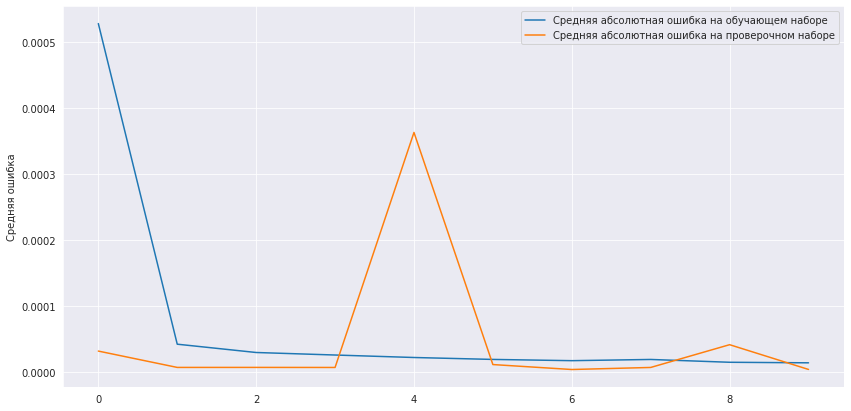

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

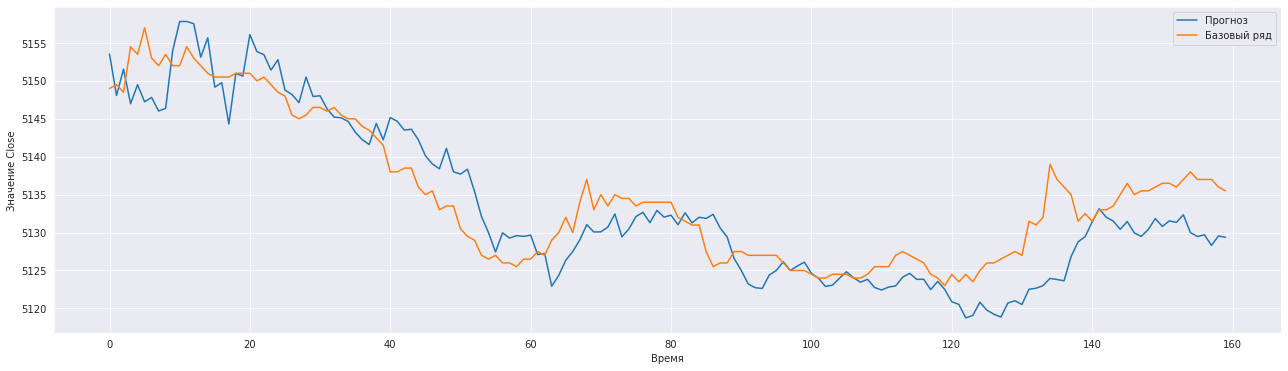

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelC #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler) #Прогнозируем данные

#Отображаем графики
showPredict(0, 160, 0, predVal, yValUnscaled)


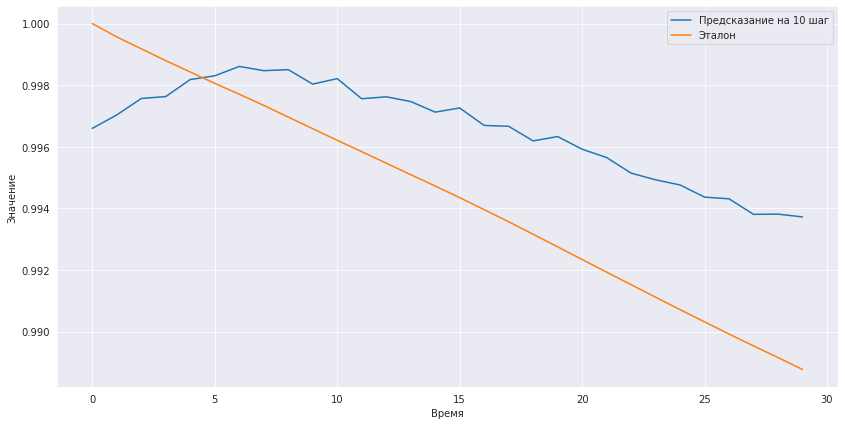

In [ ]:
#Отображаем корреляцию
showCorr([0], 30, predVal, yValUnscaled)

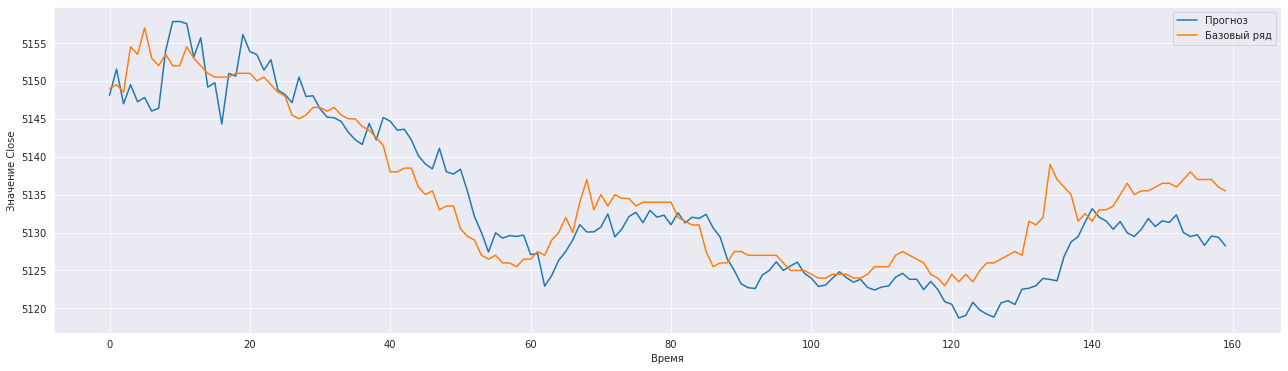

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelC #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler) #Прогнозируем данные

#Отображаем графики
showPredict(0, 160, 0, predVal[1:], yValUnscaled[:-1])